In [186]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

warnings.simplefilter(action='ignore', category=FutureWarning)

In [260]:
df = pd.read_csv('dataset.csv')

In [261]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 38 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Gender                             7043 non-null   object 
 2   Age                                7043 non-null   int64  
 3   Married                            7043 non-null   object 
 4   Number of Dependents               7043 non-null   int64  
 5   City                               7043 non-null   object 
 6   Zip Code                           7043 non-null   int64  
 7   Latitude                           7043 non-null   float64
 8   Longitude                          7043 non-null   float64
 9   Number of Referrals                7043 non-null   int64  
 10  Tenure in Months                   7043 non-null   int64  
 11  Offer                              3166 non-null   objec

### Data Preprocessing

Vamos a limpiar el dataset ver que tantos valores nulos y NaN tiene y veremos que variables debemos estandarizar o aplicar algun tipo de encoding, para saber cuales son las más relacionadas, cuales eliminamos y cuales se quedan. En principio segun mi criterio personal, podemos eliminar algunas como customer ID, Churn category, Churn Reason, entre otras...  ya que tienen relacion directa con nuestra variable objetivo "Customer Status" **y algunas no aportan nada al modelo a simple vista.**

In [262]:
df['Contract']

0             One Year
1       Month-to-Month
2       Month-to-Month
3       Month-to-Month
4       Month-to-Month
             ...      
7038          One Year
7039    Month-to-Month
7040    Month-to-Month
7041          Two Year
7042          Two Year
Name: Contract, Length: 7043, dtype: object

In [263]:
columns_del = ['Customer ID',
               'Churn Reason','Zip Code','Latitude',
               'Longitude','Avg Monthly Long Distance Charges',
               'Avg Monthly GB Download','Total Refunds',
               'Total Extra Data Charges','Total Long Distance Charges']
df.drop(columns_del, axis=1, inplace=True)

In [264]:
df.columns.values

array(['Gender', 'Age', 'Married', 'Number of Dependents', 'City',
       'Number of Referrals', 'Tenure in Months', 'Offer',
       'Phone Service', 'Multiple Lines', 'Internet Service',
       'Internet Type', 'Online Security', 'Online Backup',
       'Device Protection Plan', 'Premium Tech Support', 'Streaming TV',
       'Streaming Movies', 'Streaming Music', 'Unlimited Data',
       'Contract', 'Paperless Billing', 'Payment Method',
       'Monthly Charge', 'Total Charges', 'Total Revenue',
       'Customer Status', 'Churn Category'], dtype=object)

In [265]:
### Veremos que valores Nulos hay o NaN

nan_values = df.isna().sum()
print(nan_values,'\n')

Gender                       0
Age                          0
Married                      0
Number of Dependents         0
City                         0
Number of Referrals          0
Tenure in Months             0
Offer                     3877
Phone Service                0
Multiple Lines             682
Internet Service             0
Internet Type             1526
Online Security           1526
Online Backup             1526
Device Protection Plan    1526
Premium Tech Support      1526
Streaming TV              1526
Streaming Movies          1526
Streaming Music           1526
Unlimited Data            1526
Contract                     0
Paperless Billing            0
Payment Method               0
Monthly Charge               0
Total Charges                0
Total Revenue                0
Customer Status              0
Churn Category            5174
dtype: int64 



### Vamos a trabajar esos valores nulos, a ver de donde vienen y como podemos reemplazarlos.

Sin embargo segun un analisis anterior sabemos que los valores nulos de Offer vienen de personas que no les ha sido aplicada ninguna oferta.

In [266]:
# df['Offer']

In [267]:
# rellenando los NaN
df['Offer'].fillna(value='No Offer', inplace=True)

In [268]:
df['Churn Category'].fillna(value='No Churn', inplace=True)

In [269]:
df['Churn Category'].value_counts()

Churn Category
No Churn           5174
Competitor          841
Dissatisfaction     321
Attitude            314
Price               211
Other               182
Name: count, dtype: int64

In [270]:
df['Internet Type'].unique()

array(['Cable', 'Fiber Optic', 'DSL', nan], dtype=object)

In [271]:
# Voy a eliminar city, porque creo qeu no aporta nada.
columns_del = ['City']
df.drop(columns_del, axis=1, inplace=True)

In [272]:
# Juntemos Joined y stayed en una sola para mejorar nuestra variable objetivo
df['Customer Status'] = df['Customer Status'].replace({'Joined': 'Stayed'})

In [273]:
df['Customer Status']

0        Stayed
1        Stayed
2       Churned
3       Churned
4       Churned
         ...   
7038     Stayed
7039    Churned
7040     Stayed
7041     Stayed
7042     Stayed
Name: Customer Status, Length: 7043, dtype: object

In [274]:
nan_values = df.isna().sum()
print(nan_values,'\n')

Gender                       0
Age                          0
Married                      0
Number of Dependents         0
Number of Referrals          0
Tenure in Months             0
Offer                        0
Phone Service                0
Multiple Lines             682
Internet Service             0
Internet Type             1526
Online Security           1526
Online Backup             1526
Device Protection Plan    1526
Premium Tech Support      1526
Streaming TV              1526
Streaming Movies          1526
Streaming Music           1526
Unlimited Data            1526
Contract                     0
Paperless Billing            0
Payment Method               0
Monthly Charge               0
Total Charges                0
Total Revenue                0
Customer Status              0
Churn Category               0
dtype: int64 



In [275]:
num_valores_unicos = df.nunique()

# Mostrar el resultado
num_valores_unicos

Gender                       2
Age                         62
Married                      2
Number of Dependents        10
Number of Referrals         12
Tenure in Months            72
Offer                        6
Phone Service                2
Multiple Lines               2
Internet Service             2
Internet Type                3
Online Security              2
Online Backup                2
Device Protection Plan       2
Premium Tech Support         2
Streaming TV                 2
Streaming Movies             2
Streaming Music              2
Unlimited Data               2
Contract                     3
Paperless Billing            2
Payment Method               3
Monthly Charge            1591
Total Charges             6540
Total Revenue             6975
Customer Status              2
Churn Category               6
dtype: int64

In [276]:
df['Unlimited Data']

0       Yes
1        No
2       Yes
3       Yes
4       Yes
       ... 
7038    Yes
7039    Yes
7040    Yes
7041    Yes
7042    Yes
Name: Unlimited Data, Length: 7043, dtype: object

In [277]:
#convertir variables categoricas en variables numéricas
#churned 1
#stayed 0
label_encoder = LabelEncoder()
df['Customer Status'] = label_encoder.fit_transform(df['Customer Status'])

In [278]:
# Otras columnas binarias para LabelEncoder.
columnas = ['Internet Type', 'Streaming TV', 'Gender','Paperless Billing',
           'Unlimited Data','Streaming Music','Streaming Movies','Streaming TV',
           'Premium Tech Support','Device Protection Plan','Online Backup',
           'Online Security','Internet Service','Multiple Lines','Phone Service',
            'Married', 'Churn Category']

for columna in columnas:
    df[columna] = label_encoder.fit_transform(df[columna])

In [279]:
df['Customer Status'].value_counts()

Customer Status
1    5174
0    1869
Name: count, dtype: int64

In [280]:
nan_values = df.isna().sum()
print(nan_values,'\n')

Gender                    0
Age                       0
Married                   0
Number of Dependents      0
Number of Referrals       0
Tenure in Months          0
Offer                     0
Phone Service             0
Multiple Lines            0
Internet Service          0
Internet Type             0
Online Security           0
Online Backup             0
Device Protection Plan    0
Premium Tech Support      0
Streaming TV              0
Streaming Movies          0
Streaming Music           0
Unlimited Data            0
Contract                  0
Paperless Billing         0
Payment Method            0
Monthly Charge            0
Total Charges             0
Total Revenue             0
Customer Status           0
Churn Category            0
dtype: int64 



In [281]:
#Encoding otras caracteristicas con mas de dos clases. con One Hot Encoding de Pandas

df = pd.get_dummies(df)

In [250]:
num_valores_unicos = df.nunique()

# Mostrar el resultado
num_valores_unicos

Gender                       2
Age                         62
Married                      2
Number of Dependents        10
Number of Referrals         12
Tenure in Months            72
Offer                        6
Phone Service                2
Multiple Lines               3
Internet Service             2
Internet Type                4
Online Security              3
Online Backup                3
Device Protection Plan       3
Premium Tech Support         3
Streaming TV                 3
Streaming Movies             3
Streaming Music              3
Unlimited Data               3
Contract                     3
Paperless Billing            2
Payment Method               3
Monthly Charge            1591
Total Charges             6540
Total Revenue             6975
Customer Status              2
Churn Category               6
dtype: int64

In [209]:
# Dataset Auxiliar.
df2 = pd.read_csv('dataset.csv')

**Vamos a estandarizar datos numericos que tienen mucha divergencia, como total Charges, Total, Revenue, Monthly Charge, y tenure in months** Vamos a aplicar MinMaxScaler

In [210]:
df['Total Charges'].value_counts()

Total Charges
20.20      11
19.75       9
19.90       8
20.05       8
19.65       8
           ..
829.55      1
625.65      1
462.80      1
251.25      1
3707.60     1
Name: count, Length: 6540, dtype: int64

In [282]:
from sklearn.preprocessing import MinMaxScaler

# Seleccionar las columnas a escalar
columns_to_scale = ['Tenure in Months', 'Total Charges', 'Monthly Charge', 'Total Revenue', 'Age']

# Crear una instancia del MinMaxScaler
scaler = MinMaxScaler()

# Ajustar y transformar las columnas seleccionadas
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

# Mostrar el DataFrame resultante
df

,Gender,Age,Married,Number of Dependents,Number of Referrals,Tenure in Months,Phone Service,Multiple Lines,Internet Service,Internet Type,...,Offer_Offer B,Offer_Offer C,Offer_Offer D,Offer_Offer E,Contract_Month-to-Month,Contract_One Year,Contract_Two Year,Payment Method_Bank Withdrawal,Payment Method_Credit Card,Payment Method_Mailed Check
0,0,0.295082,1,0,2,0.112676,1,0,1,0,...,False,False,False,False,False,True,False,False,True,False
1,1,0.442623,0,0,0,0.112676,1,1,1,0,...,False,False,False,False,True,False,False,False,True,False
2,1,0.508197,0,0,0,0.042254,1,0,1,2,...,False,False,False,True,True,False,False,True,False,False
3,1,0.967213,1,0,1,0.169014,1,0,1,2,...,False,False,True,False,True,False,False,True,False,False
4,0,0.918033,1,0,3,0.028169,1,0,1,2,...,False,False,False,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,0.016393,0,0,0,0.169014,1,0,1,1,...,False,False,True,False,False,True,False,False,True,False
7039,1,0.344262,1,0,1,0.295775,1,1,1,2,...,False,False,True,False,True,False,False,True,False,False
7040,1,0.049180,0,0,0,0.014085,1,0,1,1,...,False,False,False,True,True,False,False,False,True,False
7041,1,0.032787,1,0,5,0.929577,1,0,1,0,...,False,False,False,False,False,False,True,False,True,False


In [253]:
df

,Gender,Age,Married,Number of Dependents,Number of Referrals,Tenure in Months,Phone Service,Multiple Lines,Internet Service,Internet Type,...,Offer_Offer D,Offer_Offer E,Contract_Month-to-Month,Contract_One Year,Contract_Two Year,Payment Method_Bank Withdrawal,Payment Method_Credit Card,Payment Method_Mailed Check,Customer Status_Churned,Customer Status_Stayed
0,0,0.295082,1,0,2,0.112676,1,0,1,0,...,False,False,False,True,False,False,True,False,False,True
1,1,0.442623,0,0,0,0.112676,1,1,1,0,...,False,False,True,False,False,False,True,False,False,True
2,1,0.508197,0,0,0,0.042254,1,0,1,2,...,False,True,True,False,False,True,False,False,True,False
3,1,0.967213,1,0,1,0.169014,1,0,1,2,...,True,False,True,False,False,True,False,False,True,False
4,0,0.918033,1,0,3,0.028169,1,0,1,2,...,False,False,True,False,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,0.016393,0,0,0,0.169014,1,0,1,1,...,True,False,False,True,False,False,True,False,False,True
7039,1,0.344262,1,0,1,0.295775,1,1,1,2,...,True,False,True,False,False,True,False,False,True,False
7040,1,0.049180,0,0,0,0.014085,1,0,1,1,...,False,True,True,False,False,False,True,False,False,True
7041,1,0.032787,1,0,5,0.929577,1,0,1,0,...,False,False,False,False,True,False,True,False,False,True


### Perfecto, al parecer ya tenemos un dataset mas o menos limpio y procesado. pero ahora empieza lo bueno.

Vamos a mirar las correlaciones que tienen las demas caracteristicas con nuestra variable objetivo, para ver cuales se quedan cuales se van y cuales son ams importantes.

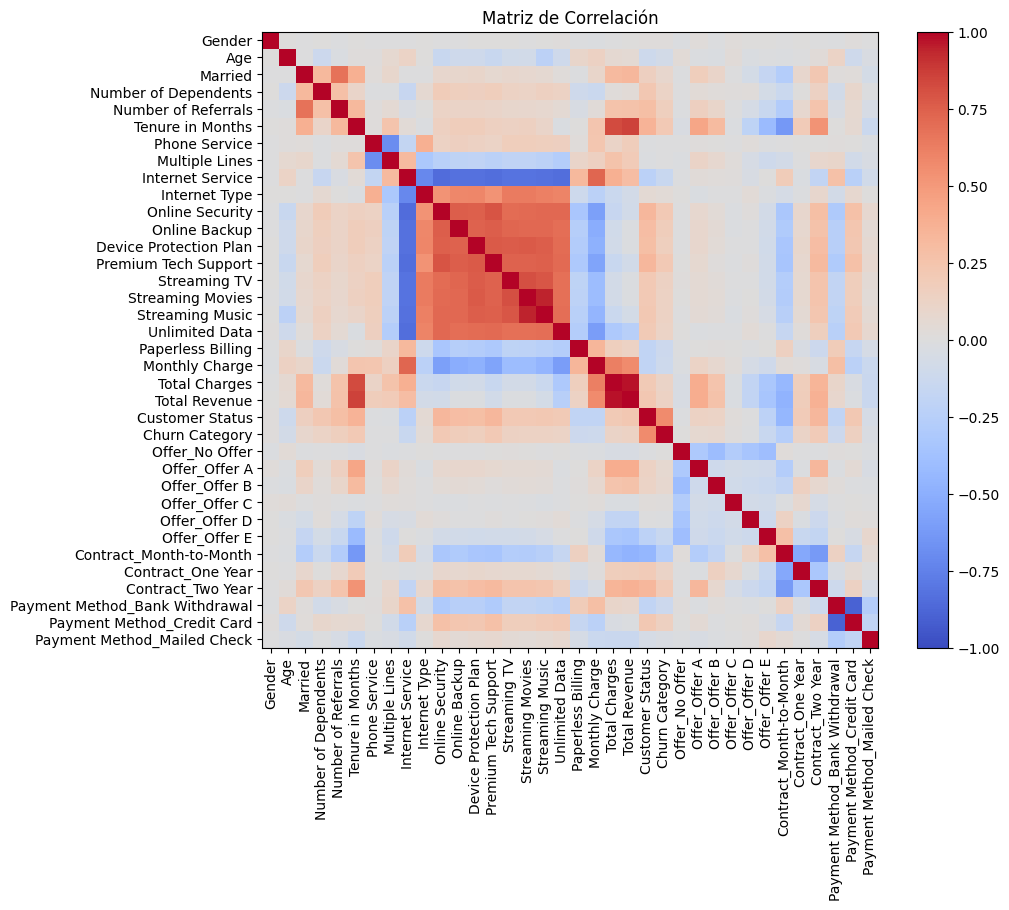

In [283]:
# Matriz de correlaciones entre caracteristicas
import pandas as pd
import matplotlib.pyplot as plt

# Calcula la matriz de correlación
correlation_matrix = df.corr()

# Configura la figura y los ejes del gráfico
fig, ax = plt.subplots(figsize=(10, 8))

# Crea el gráfico de matriz de correlación
im = ax.imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)

# Agrega una barra de color
plt.colorbar(im)

# Configura las etiquetas de los ejes
ax.set_xticks(range(len(correlation_matrix.columns)))
ax.set_yticks(range(len(correlation_matrix.columns)))
ax.set_xticklabels(correlation_matrix.columns, rotation=90)
ax.set_yticklabels(correlation_matrix.columns)

# Agrega un título
ax.set_title('Matriz de Correlación')

# Muestra el gráfico
plt.show()


### Sin sorpresas, hay muchas caracteristicas correlacionadas. que podemos eliminar.

### La correlación mide la relación lineal entre dos variables. Las características con alta correlación son más linealmente dependientes y tienen casi el mismo efecto sobre la variable dependiente. 

### Entonces, cuando dos características tienen una correlación alta, podemos descartar una de ellas. En nuestro caso, podemos eliminar características altamente correlacionadas como <span style="color:red">Multiple Lines, Online Security, OnlineBackup, DeviceProtection, Premium Tech Support, Streaming TV y Streaming Movies y quedarnos solo con una de ellas.<span>

<Axes: >

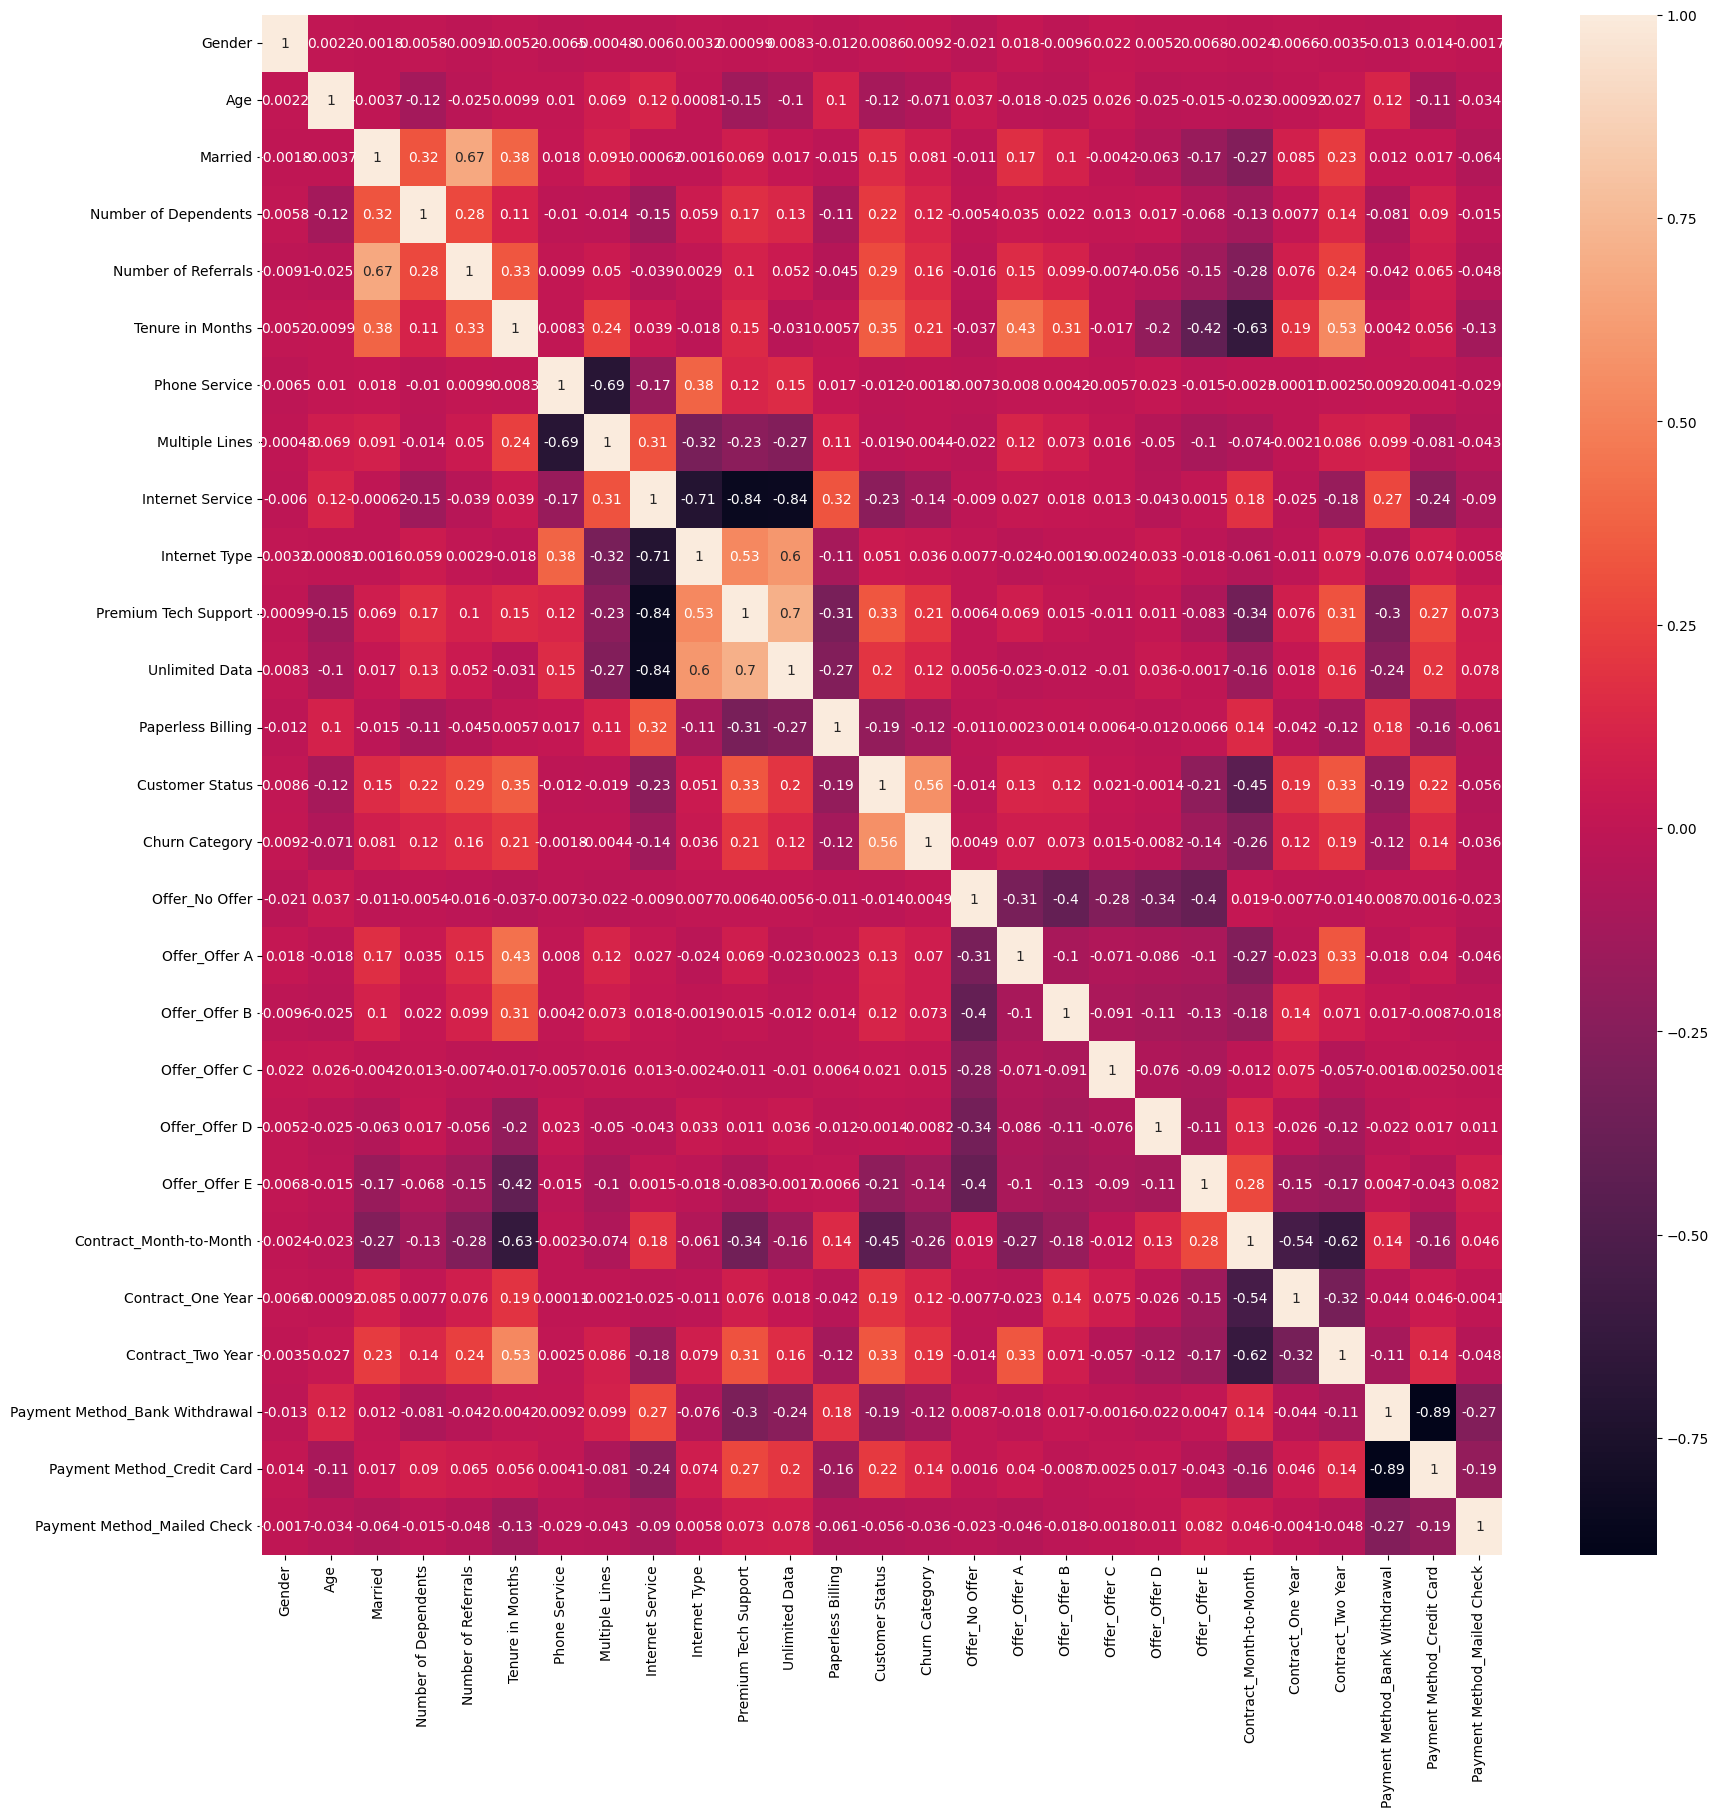

In [306]:
plt.figure(figsize=(20,20))
m_corr = df.corr()
m_corr_top = m_corr.index
sns.heatmap(df[m_corr_top].corr(), annot=True)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Paso 1: Calcular la matriz de correlación
correlation_matrix = df.corr()

# Paso 2: Seleccionar las columnas correlacionadas
threshold = 0.8
# correlated_columns = correlation_matrix[abs(correlation_matrix['Customer Status']) > threshold].index

# Paso 3: Eliminar las columnas correlacionadas
df_filtered = df.drop(correlated_columns, axis=1)

# Paso adicional: Mostrar el mapa de calor de la matriz de correlación
plt.figure(figsize=(20, 20))
sns.heatmap(df_filtered.corr(), annot=True)
plt.show()

In [307]:
df.columns.values

array(['Gender', 'Age', 'Married', 'Number of Dependents',
       'Number of Referrals', 'Tenure in Months', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Internet Type',
       'Premium Tech Support', 'Unlimited Data', 'Paperless Billing',
       'Customer Status', 'Churn Category', 'Offer_No Offer',
       'Offer_Offer A', 'Offer_Offer B', 'Offer_Offer C', 'Offer_Offer D',
       'Offer_Offer E', 'Contract_Month-to-Month', 'Contract_One Year',
       'Contract_Two Year', 'Payment Method_Bank Withdrawal',
       'Payment Method_Credit Card', 'Payment Method_Mailed Check'],
      dtype=object)

In [286]:
columns_del = ['Streaming Music','Streaming TV','Streaming Movies',
               'Online Backup','Device Protection Plan', 'Streaming Movies',
              'Total Charges']
df.drop(columns_del, axis=1, inplace=True)

In [162]:
# Funcion Para eliminar columnas

def eliminar_columna(dataframe, columna):
    if columna in dataframe.columns:
        # Eliminar la columna
        dataframe.drop(columna, axis=1, inplace=True)
        print("Columna '{}' eliminada correctamente.".format(columna))
    else:
        print("La columna '{}' no existe en el DataFrame.".format(columna))


In [317]:
eliminar_columna(df, 'Churn Category')

Columna 'Churn Category' eliminada correctamente.


In [318]:
X = df.drop('Customer Status', axis=1)
y = df['Customer Status']

In [319]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.25, random_state=47)

In [320]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [321]:
# CHURN = 0
# NO CHURN = 1

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Predecimos con regresion logistica.

lr = LogisticRegression()

lr.fit(X_train, y_train)

lr_pred = lr.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_pred)
lr_precision = precision_score(y_test, lr_pred)
lr_recall = recall_score(y_test, lr_pred)
lr_f1 = f1_score(y_test, lr_pred)
lr_report = classification_report(y_test, lr_pred)

print("Logistic Regression:")
print("Accuracy:", lr_accuracy)
print("Precision:", lr_precision)
print("Recall:", lr_recall)
print("F1-score:", lr_f1)
print("\nClassification Report:\n", lr_report)
print('----------------------------------------------------------------')
# Arboles de Decision

dt = DecisionTreeClassifier()

dt.fit(X_train, y_train)

dt_pred = dt.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_pred)
dt_precision = precision_score(y_test, dt_pred)
dt_recall = recall_score(y_test, dt_pred)
dt_f1 = f1_score(y_test, dt_pred)
dt_report = classification_report(y_test, dt_pred)

print("Decision Tree:")
print("Accuracy:", dt_accuracy)
print("Precision:", dt_precision)
print("Recall:", dt_recall)
print("F1-score:", dt_f1)
print("\nClassification Report:\n", dt_report)
print('----------------------------------------------------------------')
# Random Forest

rf = RandomForestClassifier()

rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_precision = precision_score(y_test, rf_pred)
rf_recall = recall_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred)
rf_report = classification_report(y_test, rf_pred)

print("Random Forest:")
print("Accuracy:", rf_accuracy)
print("Precision:", rf_precision)
print("Recall:", rf_recall)
print("F1-score:", rf_f1)
print("\nClassification Report:\n", rf_report)

Logistic Regression:
Accuracy: 0.8302101078932425
Precision: 0.8771796815769523
Recall: 0.8941267387944358
F1-score: 0.8855721393034826

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.65      0.67       467
           1       0.88      0.89      0.89      1294

    accuracy                           0.83      1761
   macro avg       0.78      0.77      0.78      1761
weighted avg       0.83      0.83      0.83      1761

----------------------------------------------------------------
Decision Tree:
Accuracy: 0.7802385008517888
Precision: 0.8402100525131283
Recall: 0.865533230293663
F1-score: 0.852683669585078

Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.54      0.57       467
           1       0.84      0.87      0.85      1294

    accuracy                           0.78      1761
   macro avg       0.72      0.70      0.71      1761
weighted avg       0.7

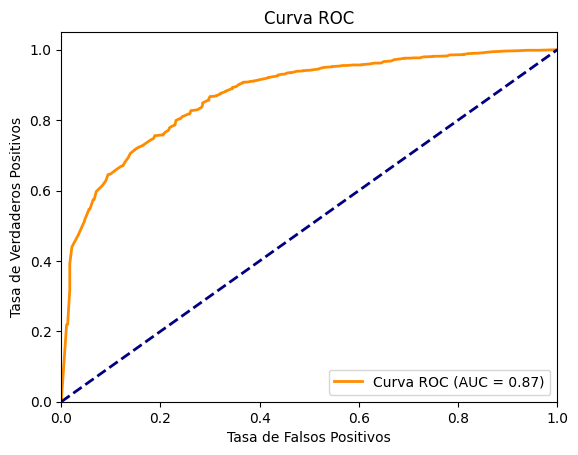

In [322]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calcular las probabilidades de predicción para la clase positiva podemos cambiar segun el modelo (rf,dt,lr)

probas = rf.predict_proba(X_test)
probas = probas[:, 1]  # Obtener las probabilidades de la clase positiva

# Calcular la tasa de verdaderos positivos, la tasa de falsos positivos y los umbrales
fpr, tpr, thresholds = roc_curve(y_test, probas)

# Calcular el área bajo la curva ROC (AUC)
roc_auc = auc(fpr, tpr)

# Trazar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

In [323]:
# Aunque no es necesario, siempre me gusta Crear una matriz DMatrix para mejorar el rendimiento de xgboost.
# Los datos de entrenamiento ya los tenemos creados.

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Definir los parámetros del modelo
params = {
    'max_depth': 4,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}

# Entrenar el modelo
num_round = 100
model = xgb.train(params, dtrain, num_round)

# Paso 6: Realizar predicciones con el conjunto de prueba
y_pred = model.predict(dtest)
y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred]

# Paso 7: Evaluar el rendimiento del modelo
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.8392958546280522
Precision: 0.8792198049512379
Recall: 0.9057187017001546
F1-score: 0.8922725542443853


AUC: 0.8963714922107967


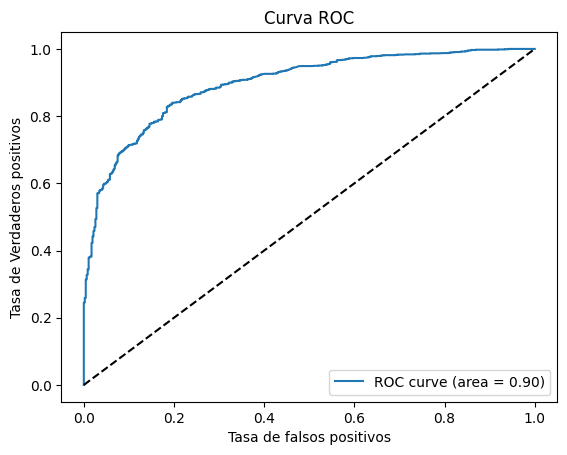

In [324]:
from sklearn.metrics import roc_curve, auc
y_prob = model.predict(dtest)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print("AUC:", roc_auc)
import matplotlib.pyplot as plt

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Línea de referencia para una clasificación aleatoria
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de Verdaderos positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()
